In [28]:
import matplotlib.pyplot as plt
import numpy as np
import xarray
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [48]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            layer.bias.initializer.run(session=session)

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [3]:
def correlation(x, y):
    x0 = x - np.mean(x, axis = 0)
    y0 = y - np.mean(y, axis = 0)
    return np.mean(x0 * y0, axis = 0) / np.sqrt((np.mean(x0**2, axis = 0) * (np.mean(y0**2, axis = 0))))

# Extracting SST, ONI and Anomaly

In [4]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

In [5]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [6]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [7]:
clm = climatology(nino34)

In [8]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [9]:
anm = SST_anomaly(nino34, clm)
oni = ONI(anm)
time = np.arange(anm.shape[0])

# Converting Time Series to Train/Validation/Test Datasets and Labels

We first decide which time series to use for training (input_signal) and which time series to predict (output_signal):

In [10]:
input_signal = np.array(anm).copy()
output_signal = np.array(oni).copy()

We then normalize the input signal for more reliable performance:

In [11]:
mean = np.mean(input_signal)
std = np.std(input_signal)

input_signal = (input_signal - mean) / std

# Variant 1

We now decide how far into the future we aim to predict (T months into the future), how much history we use to do so (H months of past values information Hmax into the past), and number of extra features (means of previous months).

In [12]:
T = 12
H = 3  
Hmax = 48
features = H + 7 + 6 + 1 # 3 months of values / 7 x 3-month averages / 6 x 4-month months / current month

Now we can create: (1) the feature matrix, i.e. the data to be used to predict the future time series value, and (2) the desired label vector.

In [13]:
np.random.seed(0)
size = input_signal.shape[0] - Hmax - T 
        
data = np.ndarray((size, features))
for i in range(size):
    data[i, 0:H] = input_signal[(i + Hmax - H):(i + Hmax)] # past H exact values
    
    for j in range(7): # 7 x 3-month average
        data[i, H + j] = np.mean(input_signal[(i + Hmax - H - 3 * (j + 1)):(i + Hmax - H - 3 * j)])
    
    for j in range(6): # 6 x 4-month months
        data[i, H + 7 + j] = np.mean(input_signal[(i + Hmax - H - 3 * 7 - 4 * (j + 1)):(i + Hmax - H - 3 * 7 - 4 * j)])
        
    data[i, H + 7 + 6] = ((i + Hmax) % 12 - np.mean(range(12))) / np.std(range(12)) # current month
    

labels = np.ndarray((size, T), dtype = np.float64)
time2D = np.zeros((size, T))

for t in range(T):
    for i in range(size):
        labels[i,t] = output_signal[i + Hmax + t]
        time2D[i, t] = time[i + Hmax + t]

We will use the first 80% of the time series as training data, the following 10% as validation and the last 10% for testing:

In [14]:
split = size // 10      

train = np.array(data[0: 8 * split])
train_labels = np.array(labels[0: 8 * split])

val = np.array(data[8 * split: 9 * split])
val_labels = np.array(labels[8 * split: 9 * split])
val_time2D = np.array(time2D[8 * split: 9 * split])

test = np.array(data[9 * split: size])
test_labels = np.array(labels[9 * split: size])

(Optional) Shuffle Training Data

In [15]:
shuffle = np.random.permutation(8 * split)
train = train[shuffle]
train_labels = train_labels[shuffle]

# Learning Optimal Weights for each t = 1, T separately:

In [51]:
(N1, N2, N3, d) = (128, 256, 256, 0.2)
epochs = 60

individual_model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1, kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2, kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2, kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(1, kernel_initializer='normal', activation = 'linear')
        ])

In [52]:
val_pred_mse = np.zeros(T)
val_pred_corr = np.zeros(T)
individual_val_pred = {}

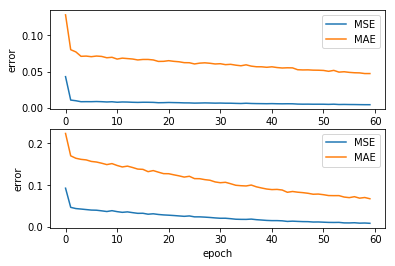

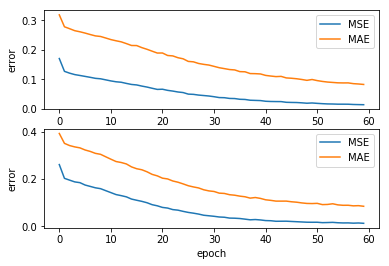

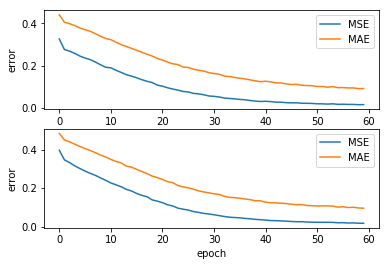

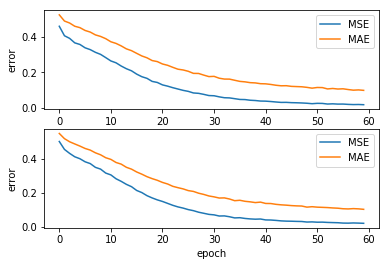

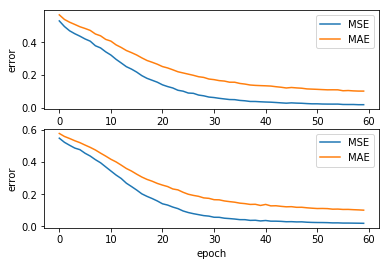

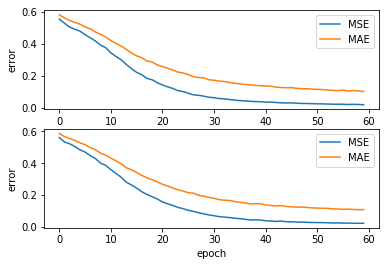

<Figure size 432x288 with 0 Axes>

In [54]:
for t in range(T):

    individual_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

    individual_history = individual_model.fit(train, train_labels[:, t], epochs = epochs, verbose = 0)
    
    individual_val_pred[t] = individual_model.predict(val).flatten() # save individual predictions for t
    
    val_pred_mse[t] = mean_squared_error(val_labels[:, t].flatten(), individual_val_pred[t])
    val_pred_corr[t] = correlation(val_labels[:, t].flatten(), individual_val_pred[t])
    
    
    # Plotting Training
    plt.subplot(2, 1, t % 2 + 1);
    
    plt.plot(individual_history.history['mean_squared_error'], label = "MSE");
    plt.plot(individual_history.history['mean_absolute_error'], label = "MAE");
    plt.ylabel('error');
    plt.xlabel('epoch');
    plt.legend();
    
    if((1 + t) % 2 == 0):
        plt.figure();
        
    reset_weights(individual_model)

# Learning Optimal Weights for all t simulatously:

In [58]:
epochs = 100

In [59]:
cumulative_model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(T,  kernel_initializer='normal', activation = 'linear')
        ])

In [60]:
cumulative_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

cumulative_history = cumulative_model.fit(train, train_labels, epochs = epochs, verbose = 0)

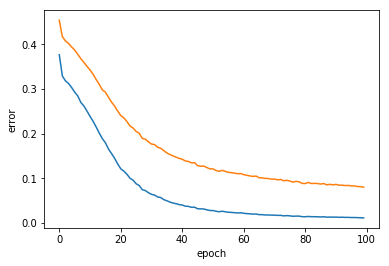

In [61]:
plt.plot(cumulative_history.history['mean_squared_error'], label = "MSE");
plt.plot(cumulative_history.history['mean_absolute_error'], label = "MAE");
plt.ylabel('error');
plt.xlabel('epoch');

In [62]:
cumulative_val_pred = cumulative_model.predict(val)

In [63]:
mult_val_pred_mse = np.zeros(T)
mult_val_pred_corr = np.zeros(T)

mult_val_pred_mse = ((val_labels - cumulative_val_pred)**2).mean(axis = 0)
mult_val_pred_corr = correlation(val_labels, cumulative_val_pred)

In [64]:
reset_weights(cumulative_model)

# Plotting Results

INDIVIDUAL vs. CUMULATIVE

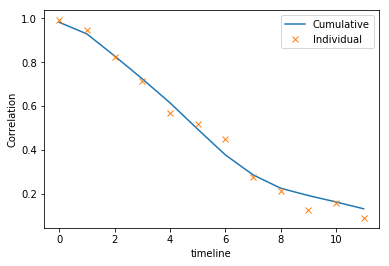

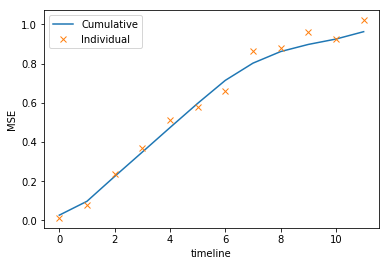

In [65]:
plt.plot(mult_val_pred_corr, label = "Cumulative");
plt.plot(val_pred_corr, 'x', label = "Individual");
plt.ylabel('Correlation');
plt.xlabel('timeline');
plt.legend();
plt.figure();

plt.plot(mult_val_pred_mse, label = "Cumulative");
plt.plot(val_pred_mse, 'x', label = "Individual");
plt.ylabel('MSE');
plt.xlabel('timeline');
plt.legend();

In [66]:
monthly_corr = np.zeros((12, T))
for m in range(12):
    monthly_corr[m] = correlation(val_labels[m::12], cumulative_val_pred[m::12])

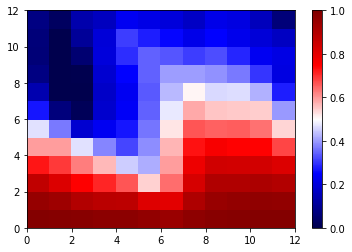

In [67]:
plt.pcolormesh(monthly_corr.T, cmap = plt.cm.seismic);
plt.clim(0, 1)
plt.colorbar();

In [68]:
monthly_rmse = np.zeros((12, T))
for m in range(12):
    monthly_rmse[m] = ((val_labels[m::12] - cumulative_val_pred[m::12])**2).mean(axis = 0)

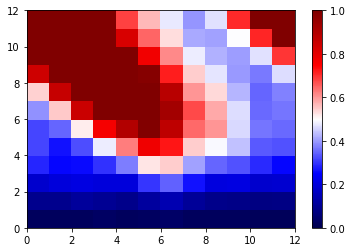

In [69]:
plt.pcolormesh(monthly_rmse.T, cmap = plt.cm.seismic);
plt.clim(0, 1)
plt.colorbar();

In [70]:
section = range(40, 50)

INDIVIDUAL

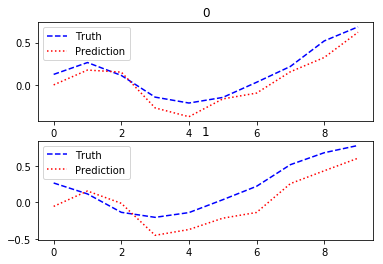

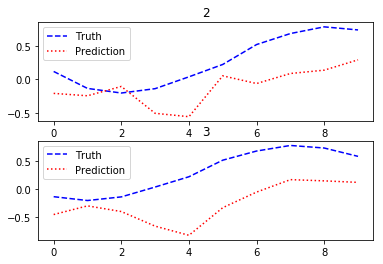

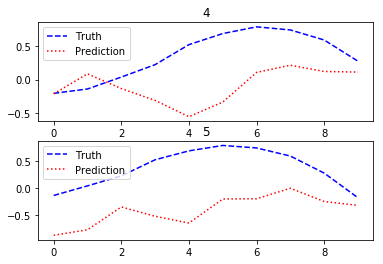

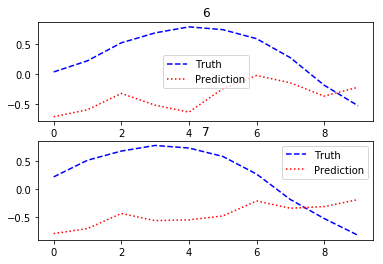

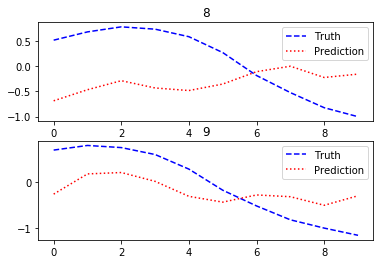

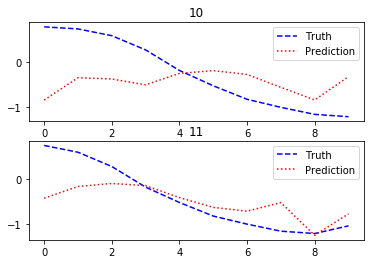

<Figure size 432x288 with 0 Axes>

In [71]:
for t in range(T):
    plt.subplot(2, 1, t % 2 + 1);
    plt.plot(val_labels[:, t][section], '--', label = "Truth", color = 'blue');
    plt.plot(individual_val_pred[t][section], ':', label = "Prediction", color = 'red');
    plt.title(t);
    plt.legend();
    if((1 + t) % 2 == 0):
        plt.figure();

CUMULATIVE

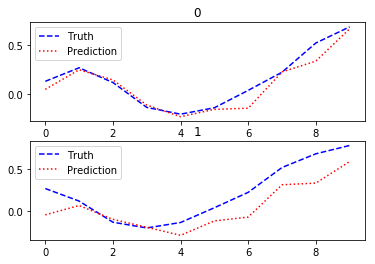

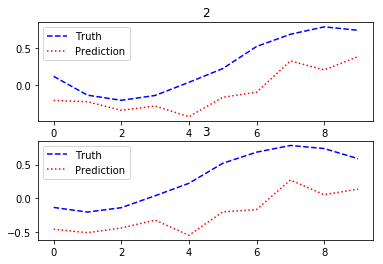

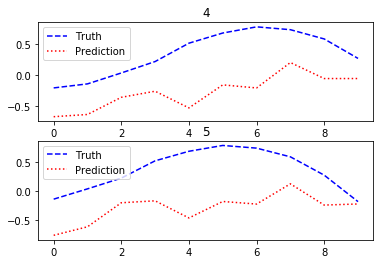

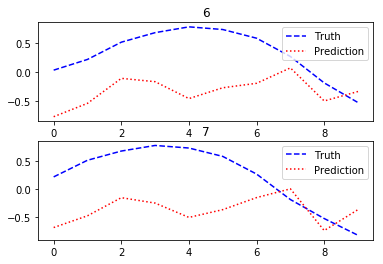

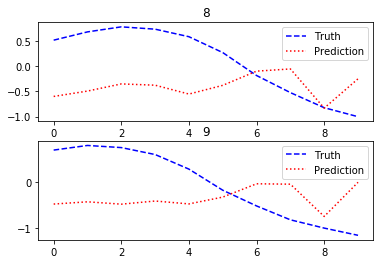

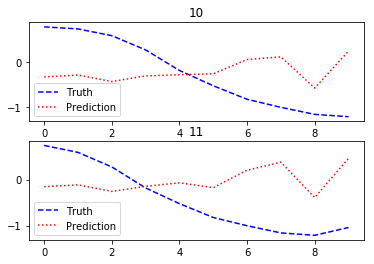

<Figure size 432x288 with 0 Axes>

In [72]:
for t in range(T):
    plt.subplot(2, 1, t % 2 + 1);
    plt.plot(val_labels[:, t][section], '--', label = "Truth", color = 'blue');
    plt.plot(cumulative_val_pred[:, t][section], ':', label = "Prediction", color = 'red');
    plt.title(t);
    plt.legend();
    if((1 + t) % 2 == 0):
        plt.figure();

In [73]:
start = 0 * 12
end = start + 5 * 12

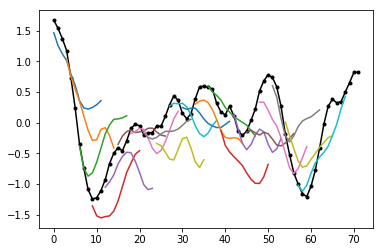

In [74]:
plt.plot(val_time2D[start:end + 12, 0].T - val_time2D[start, 0], val_labels[start:end + 12, 0], "k.-", label = "signal");
for t in range(start, end, 3):
    plt.plot(val_time2D[t] - val_time2D[start, 0], cumulative_val_pred[t], label = "%i" %(t % 12));

#plt.plot(val_time2D[start:end].T - val_time2D[start, 0], cumulative_val_pred[start:end].T);

# Comparing To Persistance

In [75]:
persistance_corr = np.zeros(T)
persistance_mse = np.zeros(T)

for t in range(T):
    persistance_corr[t] = correlation(output_signal[:(- t - 1)], output_signal[(t + 1):])
    persistance_mse[t] = mean_squared_error(output_signal[:(- t - 1)], output_signal[(t + 1):])

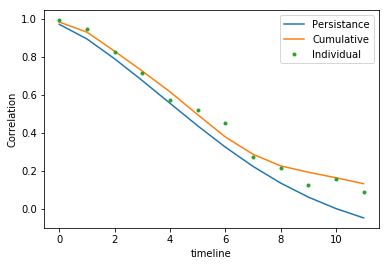

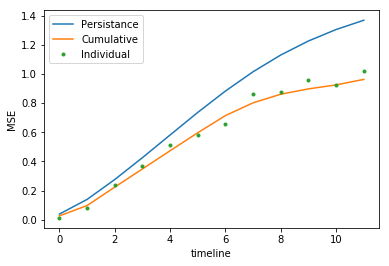

In [76]:
plt.plot(persistance_corr, label = "Persistance");
plt.plot(mult_val_pred_corr, label = "Cumulative");
plt.plot(val_pred_corr, '.', label = "Individual");
plt.ylabel('Correlation');
plt.xlabel('timeline');
plt.legend();
plt.figure();


plt.plot(persistance_mse, label = "Persistance");
plt.plot(mult_val_pred_mse, label = "Cumulative");
plt.plot(val_pred_mse, '.', label = "Individual");
plt.ylabel('MSE');
plt.xlabel('timeline');
plt.legend();

# Variant 2

In [82]:
T = 12
H = 3  
Hmax = 48
features = H + 11 + 2 + 1 # 3 months of values / 11 x 3-month averages / 2 x 6-month months / current month

In [83]:
np.random.seed(0)
size = input_signal.shape[0] - Hmax - T 
        
data = np.ndarray((size, features))
for i in range(size):
    data[i, 0:H] = input_signal[(i + Hmax - H):(i + Hmax)] # past H exact values
    
    for j in range(11): # 11 x 3-month average
        data[i, H + j] = np.mean(input_signal[(i + Hmax - H - 3 * (j + 1)):(i + Hmax - H - 3 * j)])
    
    for j in range(2): # 2 x 6-month months
        data[i, H + 11 + j] = np.mean(input_signal[(i + Hmax - H - 3 * 11 - 6 * (j + 1)):(i + Hmax - H - 3 * 11 - 6 * j)])
        
    data[i, H + 11 + 2] = ((i + Hmax) % 12 - np.mean(range(12))) / np.std(range(12)) # current month
    

labels = np.ndarray((size, T), dtype = np.float64)
time2D = np.zeros((size, T))

for t in range(T):
    for i in range(size):
        labels[i,t] = output_signal[i + Hmax + t]
        time2D[i, t] = time[i + Hmax + t]

In [84]:
split = size // 10      

train = np.array(data[0: 8 * split])
train_labels = np.array(labels[0: 8 * split])

val = np.array(data[8 * split: 9 * split])
val_labels = np.array(labels[8 * split: 9 * split])
val_time2D = np.array(time2D[8 * split: 9 * split])

test = np.array(data[9 * split: size])
test_labels = np.array(labels[9 * split: size])

In [85]:
shuffle = np.random.permutation(8 * split)
train = train[shuffle]
train_labels = train_labels[shuffle]

# Learning Separately

In [86]:
(N1, N2, N3, d) = (128, 256, 256, 0.2)
epochs = 60

individual_model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
        ])

In [87]:
val_pred_mse = np.zeros(T)
val_pred_corr = np.zeros(T)
individual_val_pred = {}

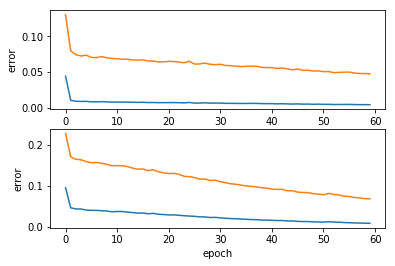

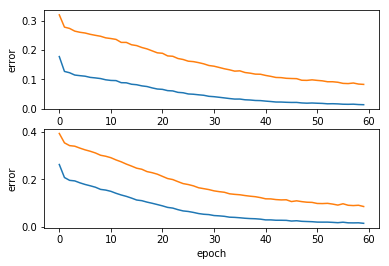

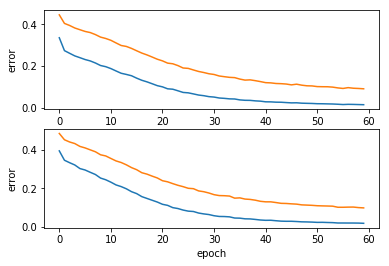

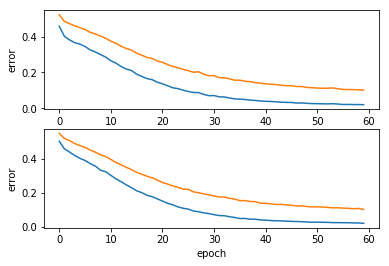

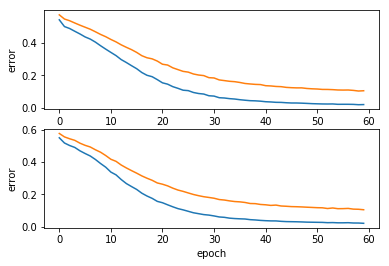

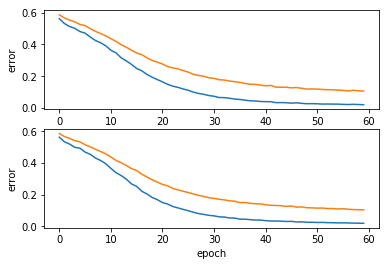

<Figure size 432x288 with 0 Axes>

In [88]:
for t in range(T):

    individual_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

    individual_history = individual_model.fit(train, train_labels[:, t], epochs = epochs, verbose = 0)
    
    individual_val_pred[t] = individual_model.predict(val).flatten() # save individual predictions for t
    
    val_pred_mse[t] = mean_squared_error(val_labels[:, t].flatten(), individual_val_pred[t])
    val_pred_corr[t] = correlation(val_labels[:, t].flatten(), individual_val_pred[t])
    
    
    # Plotting Training
    plt.subplot(2, 1, t % 2 + 1);
    
    plt.plot(individual_history.history['mean_squared_error']);
    plt.plot(individual_history.history['mean_absolute_error']);
    plt.ylabel('error');
    plt.xlabel('epoch');
    
    if((1 + t) % 2 == 0):
        plt.figure();
        
    reset_weights(individual_model)

# Learning Cumulatively

In [89]:
epochs = 100

In [90]:
cumulative_model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(T,  kernel_initializer='normal', activation = 'linear')
        ])

In [91]:
cumulative_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

cumulative_history = cumulative_model.fit(train, train_labels, epochs = epochs, verbose = 0)

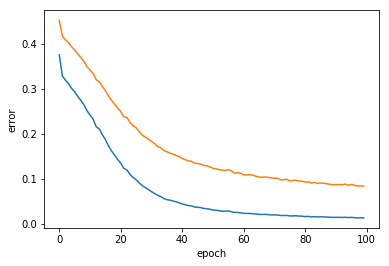

In [92]:
plt.plot(cumulative_history.history['mean_squared_error'], label = "MSE");
plt.plot(cumulative_history.history['mean_absolute_error'], label = "MAE");
plt.ylabel('error');
plt.xlabel('epoch');

In [93]:
cumulative_val_pred = cumulative_model.predict(val)

In [94]:
mult_val_pred_mse = np.zeros(T)
mult_val_pred_corr = np.zeros(T)

mult_val_pred_mse = ((val_labels - cumulative_val_pred)**2).mean(axis = 0)
mult_val_pred_corr = correlation(val_labels, cumulative_val_pred)

In [95]:
reset_weights(cumulative_model)

# Plotting Results

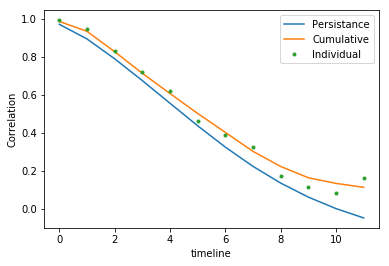

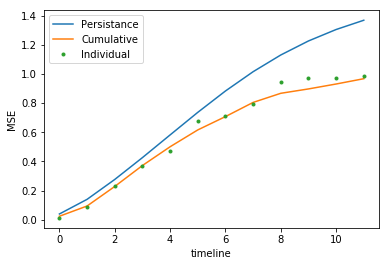

In [96]:
plt.plot(persistance_corr, label = "Persistance");
plt.plot(mult_val_pred_corr, label = "Cumulative");
plt.plot(val_pred_corr, '.', label = "Individual");
plt.ylabel('Correlation');
plt.xlabel('timeline');
plt.legend();
plt.figure();


plt.plot(persistance_mse, label = "Persistance");
plt.plot(mult_val_pred_mse, label = "Cumulative");
plt.plot(val_pred_mse, '.', label = "Individual");
plt.ylabel('MSE');
plt.xlabel('timeline');
plt.legend();

# Variant 3

In [97]:
T = 12
H = 3  
Hmax = 48
features = H + 3 + 6 + 1 # 3 months of values / 3 x 3-month averages / 6 x 6-month months / current month

In [98]:
np.random.seed(0)
size = input_signal.shape[0] - Hmax - T 
        
data = np.ndarray((size, features))
for i in range(size):
    data[i, 0:H] = input_signal[(i + Hmax - H):(i + Hmax)] # past H exact values
    
    for j in range(3): # 3 x 3-month average
        data[i, H + j] = np.mean(input_signal[(i + Hmax - H - 3 * (j + 1)):(i + Hmax - H - 3 * j)])
    
    for j in range(6): # 6 x 6-month months
        data[i, H + 3 + j] = np.mean(input_signal[(i + Hmax - H - 3 * 3 - 6 * (j + 1)):(i + Hmax - H - 3 * 3 - 6 * j)])
        
    data[i, H + 3 + 6] = ((i + Hmax) % 12 - np.mean(range(12))) / np.std(range(12)) # current month
    

labels = np.ndarray((size, T), dtype = np.float64)
time2D = np.zeros((size, T))

for t in range(T):
    for i in range(size):
        labels[i,t] = output_signal[i + Hmax + t]
        time2D[i, t] = time[i + Hmax + t]

In [99]:
split = size // 10      

train = np.array(data[0: 8 * split])
train_labels = np.array(labels[0: 8 * split])

val = np.array(data[8 * split: 9 * split])
val_labels = np.array(labels[8 * split: 9 * split])
val_time2D = np.array(time2D[8 * split: 9 * split])

test = np.array(data[9 * split: size])
test_labels = np.array(labels[9 * split: size])

In [100]:
shuffle = np.random.permutation(8 * split)
train = train[shuffle]
train_labels = train_labels[shuffle]

In [101]:
(N1, N2, N3, d) = (128, 256, 256, 0.2)
epochs = 60

individual_model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
        ])

In [102]:
val_pred_mse = np.zeros(T)
val_pred_corr = np.zeros(T)
individual_val_pred = {}

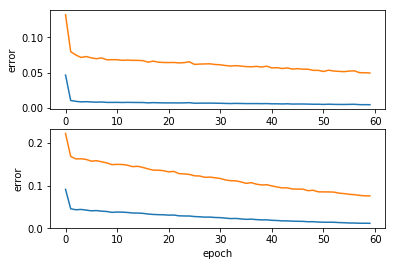

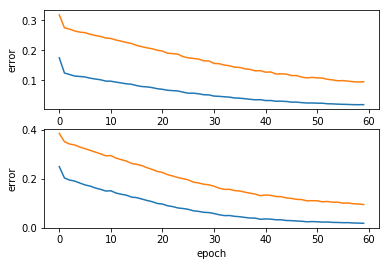

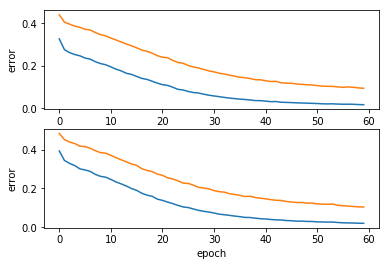

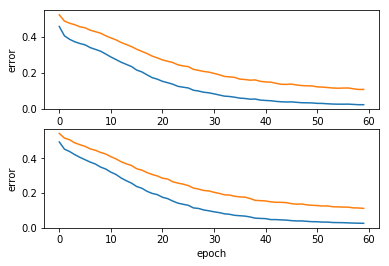

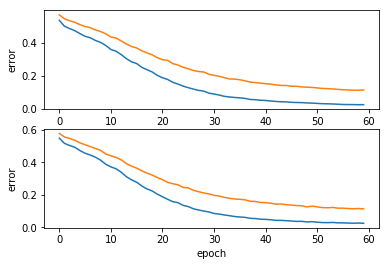

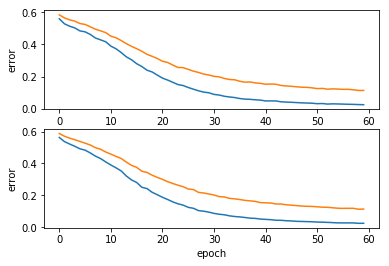

<Figure size 432x288 with 0 Axes>

In [103]:
for t in range(T):

    individual_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

    individual_history = individual_model.fit(train, train_labels[:, t], epochs = epochs, verbose = 0)
    
    individual_val_pred[t] = individual_model.predict(val).flatten() # save individual predictions for t
    
    val_pred_mse[t] = mean_squared_error(val_labels[:, t].flatten(), individual_val_pred[t])
    val_pred_corr[t] = correlation(val_labels[:, t].flatten(), individual_val_pred[t])
    
    
    # Plotting Training
    plt.subplot(2, 1, t % 2 + 1);
    
    plt.plot(individual_history.history['mean_squared_error']);
    plt.plot(individual_history.history['mean_absolute_error']);
    plt.ylabel('error');
    plt.xlabel('epoch');
    
    if((1 + t) % 2 == 0):
        plt.figure();
        
    reset_weights(individual_model)

In [104]:
epochs = 100

In [105]:
cumulative_model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(T,  kernel_initializer='normal', activation = 'linear')
        ])

In [106]:
cumulative_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])

cumulative_history = cumulative_model.fit(train, train_labels, epochs = epochs, verbose = 0)

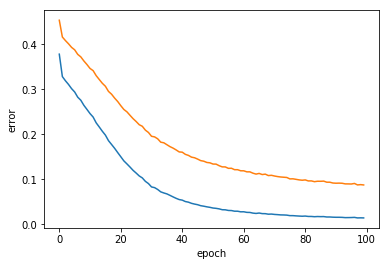

In [111]:
plt.plot(cumulative_history.history['mean_squared_error'], label = "MSE");
plt.plot(cumulative_history.history['mean_absolute_error'], label = "MAE");
plt.ylabel('error');
plt.xlabel('epoch');

In [107]:
cumulative_val_pred = cumulative_model.predict(val)

In [108]:
mult_val_pred_mse = np.zeros(T)
mult_val_pred_corr = np.zeros(T)

mult_val_pred_mse = ((val_labels - cumulative_val_pred)**2).mean(axis = 0)
mult_val_pred_corr = correlation(val_labels, cumulative_val_pred)

In [109]:
reset_weights(cumulative_model)

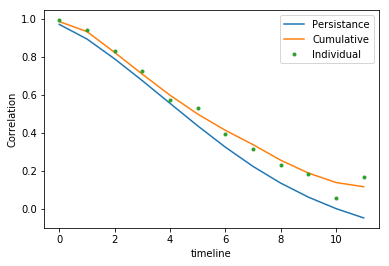

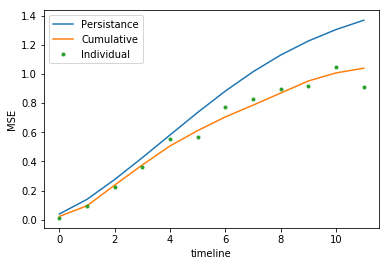

In [110]:
plt.plot(persistance_corr, label = "Persistance");
plt.plot(mult_val_pred_corr, label = "Cumulative");
plt.plot(val_pred_corr, '.', label = "Individual");
plt.ylabel('Correlation');
plt.xlabel('timeline');
plt.legend();
plt.figure();


plt.plot(persistance_mse, label = "Persistance");
plt.plot(mult_val_pred_mse, label = "Cumulative");
plt.plot(val_pred_mse, '.', label = "Individual");
plt.ylabel('MSE');
plt.xlabel('timeline');
plt.legend();